In [21]:
import os
import re
import torch
import torch.nn as nn
from torch.nn import functional as F
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython import display
from torch.nn.functional import scaled_dot_product_attention
from einops import rearrange

torch.manual_seed(69)
torch.set_printoptions(profile="short", sci_mode=False, linewidth=100000)
torch.set_float32_matmul_precision('high')
# this script is configured to run on a RTX 3060 12GB GPU. you'll want to adjust the model sizes and batch sizes for other devices
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 50
plt.rcParams['axes.grid'] = True
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True

USE_SDPA = False
USE_TORCH_COMPILE = False

# Data Prep

In [2]:
# we use this 40mb file of concatenated anime subtitles as our dataset
# just the right size for toy experiments like this I think
with open('animesubs_fixed.txt', 'r') as f:
    text = f.read()
print("length of dataset in characters: ", len(text))

length of dataset in characters:  39525728


In [3]:
print(text[:500])

Open your mind. Open your mind.

Far beyond the deep blue Earth, you and I shall meet...

AH! MY GODDESS

A snow-white feather comes fluttering down, swaying gently in the air.

Without holding back, I want to envelope you, my one and only love.

I know I have the power to protect the one I love, right here in my hands.

Open your mind. Just as I've always dreamed.

Let the wind carry off your hopes, faraway.

I have wings nobody can see. Look, you have them, too.

They'll take us to where we ca


In [4]:
# remove japanese characters
text = ''.join(filter(lambda character:ord(character) < 0x3000, text))

In [5]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print("unique characters:", vocab_size, ''.join(chars))

unique characters: 85 
 !'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_abcdefghijklmnopqrstuvwxyz|


In [6]:
# yes, all language models will be character level, which isn't ideal but it's good for simplicity
# very simple tokenizer
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}
# add special token for padding
stoi[''] = len(stoi)
itos[len(itos)] = ''
print(stoi)
print(itos)
encode = lambda s: [stoi[ch] for ch in s]
decode = lambda l: ''.join([itos[i] for i in l])
print("encoded:", encode(text[:20]))
print("decoded:", decode(encode(text[:20])))
vocab_size = len(itos)
print("vocab size:", vocab_size)

{'\n': 0, ' ': 1, '!': 2, "'": 3, '(': 4, ')': 5, '*': 6, '+': 7, ',': 8, '-': 9, '.': 10, '/': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '5': 17, '6': 18, '7': 19, '8': 20, '9': 21, ':': 22, ';': 23, '<': 24, '=': 25, '>': 26, '?': 27, '@': 28, 'A': 29, 'B': 30, 'C': 31, 'D': 32, 'E': 33, 'F': 34, 'G': 35, 'H': 36, 'I': 37, 'J': 38, 'K': 39, 'L': 40, 'M': 41, 'N': 42, 'O': 43, 'P': 44, 'Q': 45, 'R': 46, 'S': 47, 'T': 48, 'U': 49, 'V': 50, 'W': 51, 'X': 52, 'Y': 53, 'Z': 54, '[': 55, ']': 56, '_': 57, 'a': 58, 'b': 59, 'c': 60, 'd': 61, 'e': 62, 'f': 63, 'g': 64, 'h': 65, 'i': 66, 'j': 67, 'k': 68, 'l': 69, 'm': 70, 'n': 71, 'o': 72, 'p': 73, 'q': 74, 'r': 75, 's': 76, 't': 77, 'u': 78, 'v': 79, 'w': 80, 'x': 81, 'y': 82, 'z': 83, '|': 84, '': 85}
{0: '\n', 1: ' ', 2: '!', 3: "'", 4: '(', 5: ')', 6: '*', 7: '+', 8: ',', 9: '-', 10: '.', 11: '/', 12: '0', 13: '1', 14: '2', 15: '3', 16: '4', 17: '5', 18: '6', 19: '7', 20: '8', 21: '9', 22: ':', 23: ';', 24: '<', 25: '=', 26: '>', 

In [7]:
data = torch.tensor(encode(text), dtype=torch.int64)
data.shape

torch.Size([39525728])

In [8]:
data[:100]

tensor([43, 73, 62, 71,  1, 82, 72, 78, 75,  1, 70, 66, 71, 61, 10,  1, 43, 73, 62, 71,  1, 82, 72, 78, 75,  1, 70, 66, 71, 61, 10,  0,  0, 34, 58, 75,  1, 59, 62, 82, 72, 71, 61,  1, 77, 65, 62,  1, 61, 62, 62, 73,  1, 59, 69, 78, 62,  1, 33, 58, 75, 77, 65,  8,  1, 82, 72, 78,  1, 58, 71, 61,  1, 37,  1, 76, 65, 58, 69, 69,  1, 70, 62, 62, 77, 10, 10, 10,  0,  0, 29, 36,  2,  1, 41, 53,  1, 35, 43, 32])

In [9]:
n = int(len(data) * 0.99)
train_data = data[:n]
val_data = data[n:]
print(train_data.shape, val_data.shape)

torch.Size([39130470]) torch.Size([395258])


In [10]:
seq_len = 8
train_data[:seq_len+1]

tensor([43, 73, 62, 71,  1, 82, 72, 78, 75])

In [ ]:
def get_batch(split, seq_len, batch_size=4, n_future_tokens=1):
    """
    Generate a batch of data for training a model to predict multiple future tokens.

    For each input sequence in the batch, the target consists of the next `n_future_tokens` 
    that follow each token in the input sequence.
    """
    # Select the appropriate dataset
    data = train_data if split == 'train' else val_data
    
    # Generate random starting indices for the batches
    # We subtract n_future_tokens as well to ensure the target sequences don't go out of bounds
    max_start_index = len(data) - seq_len - n_future_tokens
    ix = torch.randint(max_start_index, (batch_size,))
    
    # Create the input sequences (x)
    x = torch.stack([data[i:i+seq_len] for i in ix])
    
    # Create the target sequences (y) for multi-token prediction
    # For each position in the input sequence, the target is the next `n_future_tokens`
    y = torch.stack([
        torch.stack([data[i+j+1 : i+j+1+n_future_tokens] for j in range(seq_len)])
        for i in ix
    ])

    y = y.transpose(1, 2)

    if n_future_tokens == 1:
        y = y.squeeze(1)
    
    # Move tensors to the specified device
    return x.to(device), y.to(device)

xb, yb = get_batch('train', 64, 2, 3)
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

inputs:
torch.Size([2, 64])
tensor([[62,  1, 58,  1, 64, 72, 72, 61,  1, 73, 62, 75, 76, 72, 71,  1, 41, 72, 68, 58,  9, 76, 58, 71,  8,  1, 66, 77,  3, 76,  1, 66, 70, 73, 72, 76, 76, 66, 59, 69, 62,  1, 63, 72, 75,  1, 70, 62,  1, 77, 72,  1, 64, 72,  1, 77, 72,  1, 77, 65, 66, 76,  1, 76],
        [66, 71, 69, 82,  1, 66, 76,  1, 76, 77, 75, 58, 71, 64, 62,  1, 77, 65, 58, 77,  1, 77, 65, 62, 82,  1, 61, 72, 71,  3, 77,  1, 65, 72, 80, 69, 10,  0,  0, 37,  1, 65, 72, 73, 62,  1, 66, 77,  1, 64, 72, 62, 76,  1, 80, 62, 69, 69, 10,  0,  0, 29, 75, 62]], device='cuda:0')
targets:
torch.Size([2, 3, 64])
tensor([[[ 1, 58,  1, 64, 72, 72, 61,  1, 73, 62, 75, 76, 72, 71,  1, 41, 72, 68, 58,  9, 76, 58, 71,  8,  1, 66, 77,  3, 76,  1, 66, 70, 73, 72, 76, 76, 66, 59, 69, 62,  1, 63, 72, 75,  1, 70, 62,  1, 77, 72,  1, 64, 72,  1, 77, 72,  1, 77, 65, 66, 76,  1, 76, 60],
         [58,  1, 64, 72, 72, 61,  1, 73, 62, 75, 76, 72, 71,  1, 41, 72, 68, 58,  9, 76, 58, 71,  8,  1, 66, 77,  3, 76,  

: 

# Training Prep

In [12]:
# Make all steps, sequence lengths, and batch size the same
total_steps = 1250
seq_len = 128
batch_size = 512 # these are small models so we can use large batch sizes to fully utilize the GPU
# should cover around 2x the dataset
total_steps * seq_len * batch_size

81920000

In [58]:
def train(model, optimizer, seq_len, batch_size, total_steps, val_steps=10, val_interval=50, n_future_tokens=1):
    losses = []
    val_losses = []
    # live plot
    fig, ax = plt.subplots()
    dh = display.display(fig, display_id=True)
    for steps in (bar := tqdm(range(total_steps))):  # increase number of steps for good results...
        # sample a batch of data
        xb, yb = get_batch('train', seq_len=seq_len, batch_size=batch_size, n_future_tokens=n_future_tokens)

        # evaluate the loss
        logits, loss = model(xb, yb)

        # backprop
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        bar.set_description(f"loss: {loss.item():.2f}, val loss: {val_losses[-1] if val_losses else 0:.2f}")
        losses.append(loss.item())
        if steps % val_interval == 0:
            # Calculate validation loss
            with torch.no_grad():
                val_loss = 0
                for _ in range(val_steps):
                    xb, yb = get_batch('val', seq_len=seq_len, batch_size=batch_size, n_future_tokens=n_future_tokens)
                    _, loss = model(xb, yb)
                    val_loss += loss.item()
                val_loss /= val_steps
                val_losses.append(val_loss)
            ax.clear()
            ax.plot(losses, color='blue', label='train loss', alpha=0.7)
            ax.plot(range(0, len(losses), val_interval), val_losses, color='red', label='val loss', alpha=0.7)
            ax.set_ylim(1, 4)
            ax.legend()
            dh.update(fig)
    print('final loss:', loss.item(), 'final val loss:', val_loss)

# Transformers

## Classic Transformer

In [14]:
def precompute_freqs_cis(dim: int, end: int, theta: float = 10000.0):
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
    t = torch.arange(end, device=freqs.device, dtype=torch.float32)
    freqs = torch.outer(t, freqs)
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)  # complex64
    return freqs_cis.to(device)

@torch._dynamo.disable
def apply_rotary_emb(
    xq: torch.Tensor,
    xk: torch.Tensor,
    freqs_cis: torch.Tensor,
):
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
    # freqs_cis = reshape_for_broadcast(freqs_cis, xq_)
    q_shape = [d if i == 1 or i == xq_.ndim - 1 else 1 for i, d in enumerate(xq_.shape)]
    k_shape = [d if i == 1 or i == xk_.ndim - 1 else 1 for i, d in enumerate(xk_.shape)]
    T_q = xq_.shape[-2]
    q_freqs_cis = freqs_cis[-T_q:].view(*q_shape)
    k_freqs_cis = freqs_cis.view(*k_shape)
    xq_out = torch.view_as_real(xq_ * q_freqs_cis).flatten(2)
    xk_out = torch.view_as_real(xk_ * k_freqs_cis).flatten(2)
    return xq_out.type_as(xq), xk_out.type_as(xk)

class RMSNorm(torch.nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(x.float()).type_as(x)
        return output * self.weight

class SelfAttentionHead(nn.Module):
    """ one head of self-attention """
    def __init__(self, seq_len, n_embd, head_size):
        super().__init__()
        self.seq_len = seq_len
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(seq_len, seq_len)))

    def forward(self, x, freqs_cis, kv_cache=None):
        B, T, C = x.shape
        _, T_past, _ = kv_cache[0].shape if kv_cache is not None and kv_cache[0] is not None else (0, 0, 0)
        q = self.query(x) # (B,T,C)
        k = self.key(x)   # (B,T,C)
        v = self.value(x) # (B,T,C)

        if kv_cache is not None:
            k_past, v_past = kv_cache
            if k_past is not None:
                k = torch.cat((k_past, k), dim=1)
                v = torch.cat((v_past, v), dim=1)
            if k.shape[1] > seq_len:
                k = k[:, -seq_len:]
                v = v[:, -seq_len:]
                freqs_cis = freqs_cis[-seq_len:]
            kv_cache = (k, v)

        q, k = apply_rotary_emb(q, k, freqs_cis)

        # compute attention scores ("affinities")
        if not USE_SDPA:
            wei = q @ k.transpose(-2,-1) # (B, T, C) @ (B, C, T) -> (B, T, T)
            wei = wei * C**-0.5 # scaled attention
            wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
            wei = F.softmax(wei, dim=-1) # (B, T, T)

            # perform the weighted aggregation of the values
            out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        else:
            # use scaled dot-product attention for better performance
            # Transform to (B, H, T, C) first
            q = q.view(B, 1, T, -1) # This is confusing since C should be head_dim, but in this code, this is head_size after splitting the head
            k = k.view(B, 1, T, -1)
            v = v.view(B, 1, T, -1)
            out = scaled_dot_product_attention(q, k, v, attn_mask=self.tril[:T, :T], dropout_p=0.0)
            # Transform back to (B, T, C)
            out = out.view(B, T, -1)
        return out, kv_cache

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """
    def __init__(self, seq_len, num_heads, n_embd, head_size):
        super().__init__()
        self.heads = nn.ModuleList([SelfAttentionHead(seq_len, n_embd, head_size) for _ in range(num_heads)])
        self.o = nn.Linear(num_heads*head_size, n_embd)

    def forward(self, x, freqs_cis, kv_cache=None):
        head_outs = [h(x, freqs_cis, None if kv_cache is None else kv_cache[i]) for i, h in enumerate(self.heads)]
        kv_cache = [h[1] for h in head_outs]
        out = torch.cat([h[0] for h in head_outs], dim=-1) # concat single-head results
        out = self.o(out)
        return out, kv_cache

class FeedForward(nn.Module):
    def __init__(self, n_embed, n_hidden):
        super().__init__()
        self.lin_1 = nn.Linear(n_embed, n_hidden)
        self.lin_2 = nn.Linear(n_hidden, n_embed)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.lin_1(x)
        x = self.relu(x)
        x = self.lin_2(x)
        return x

class Block(nn.Module):
    def __init__(self, seq_len, n_heads, n_embd):
        super().__init__()
        self.sa_heads = MultiHeadAttention(seq_len, n_heads, n_embd, n_embd//n_heads)
        self.ff_layer = FeedForward(n_embd, n_embd*4)
        self.sa_norm = RMSNorm(n_embd)
        self.ff_norm = RMSNorm(n_embd)
    
    def forward(self, x, freqs_cis, kv_cache=None):
        a, kv_cache = self.sa_heads(self.sa_norm(x), freqs_cis, kv_cache)
        h = x + a
        o = h + self.ff_layer(self.ff_norm(h))
        return o, kv_cache
    
class TransformerLM(nn.Module):
    def __init__(self, vocab_size, seq_len, embed_size, head_num, layer_num):
        super().__init__()
        self.layer_num = layer_num
        self.head_num = head_num
        self.seq_len = seq_len
        # embed raw tokens to a lower dimensional embedding with embed_size
        self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
        # Language Modelling (?) Head is a standard linear layer to go from 
        # embeddings back to logits of vocab_size
        self.lm_head = nn.Linear(embed_size, vocab_size)
        # transformer blocks
        self.blocks = nn.ModuleList([Block(seq_len, head_num, embed_size) for _ in range(layer_num)])
        # precompute frequencies for rotary embeddings
        self.freqs_cis = precompute_freqs_cis(embed_size//head_num, seq_len*2)

    def forward(self, idx, targets=None, kv_cache=None):
        B, T = idx.shape
        _, T_past, _ = kv_cache[0][0][0].shape if kv_cache is not None and kv_cache[0][0][0] is not None else (0, 0, 0)
        # idx and targets are both (B,T) tensor of integers
        tok_embd = self.token_embedding_table(idx) # (B,T,C)
        x = tok_embd
        # go through blocks
        freqs_cis = self.freqs_cis[:T_past+T]
        for i, block in enumerate(self.blocks):
            x, cache = block(x, freqs_cis, None if kv_cache is None else kv_cache[i])
            if kv_cache is not None:
                kv_cache[i] = cache
        # get logits with linear layer
        logits = self.lm_head(x) # (B,T,C)
        
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    def generate(self, idx, max_new_tokens, temperature=1, use_cache=True):
        if use_cache:
            # initialize key-value cache
            kv_cache = [[(None, None) for _ in range(self.head_num)] for _ in range(self.layer_num)]
            # idx is (B, T) array of indices in the current context
            # crop idx to the last seq_len tokens
            idx_context = idx[:, -self.seq_len:]
            for _ in range(max_new_tokens):
                # get the predictions
                logits, loss = self(idx_context, kv_cache=kv_cache)
                # focus only on the last time step
                logits = logits[:, -1, :] # becomes (B, C)
                # apply temperature
                logits = logits / temperature if temperature > 0 else logits
                # apply softmax to get probabilities
                probs = F.softmax(logits, dim=-1) # (B, C)
                # sample from the distribution
                idx_next = torch.multinomial(probs, num_samples=1) if temperature > 0 else torch.argmax(probs, dim=-1, keepdim=True) # (B, 1)
                # append sampled index to the running sequence
                idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
                # since we have kv cache, only need to pass new token
                idx_context = idx_next
            return idx
        else:
            # idx is (B, T) array of indices in the current context
            for _ in range(max_new_tokens):
                #crop idx to the last seq_len tokens
                idx_context = idx[:, -self.seq_len:]
                # get the predictions
                logits, loss = self(idx_context)
                # focus only on the last time step
                logits = logits[:, -1, :] # becomes (B, C)
                # apply temperature
                logits = logits / temperature if temperature > 0 else logits
                # apply softmax to get probabilities
                probs = F.softmax(logits, dim=-1) # (B, C)
                # sample from the distribution
                idx_next = torch.multinomial(probs, num_samples=1) if temperature > 0 else torch.argmax(probs, dim=-1, keepdim=True) # (B, 1)
                # append sampled index to the running sequence
                idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
            return idx

In [15]:
# Test forward pass
# (self, vocab_size, seq_len, embed_size, head_num, layer_num)
m = TransformerLM(
    vocab_size=vocab_size, 
    seq_len=seq_len, 
    embed_size=128, 
    head_num=2, 
    layer_num=5, 
)
m.to(device)
if USE_TORCH_COMPILE:
    m = torch.compile(m, mode='reduce-overhead')
xb, yb = get_batch('train', 5, 1)
logits, loss = m(xb, yb)
total_params = sum(p.numel() for p in m.parameters() if p.requires_grad)
total_params

1010262

Without Compile is 47s
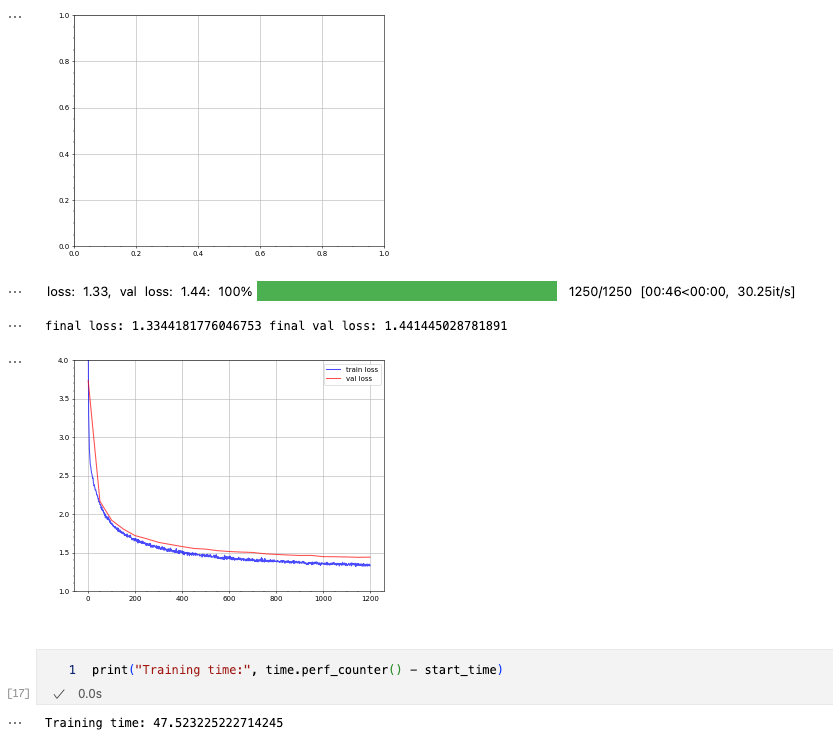

With Compile is 44s

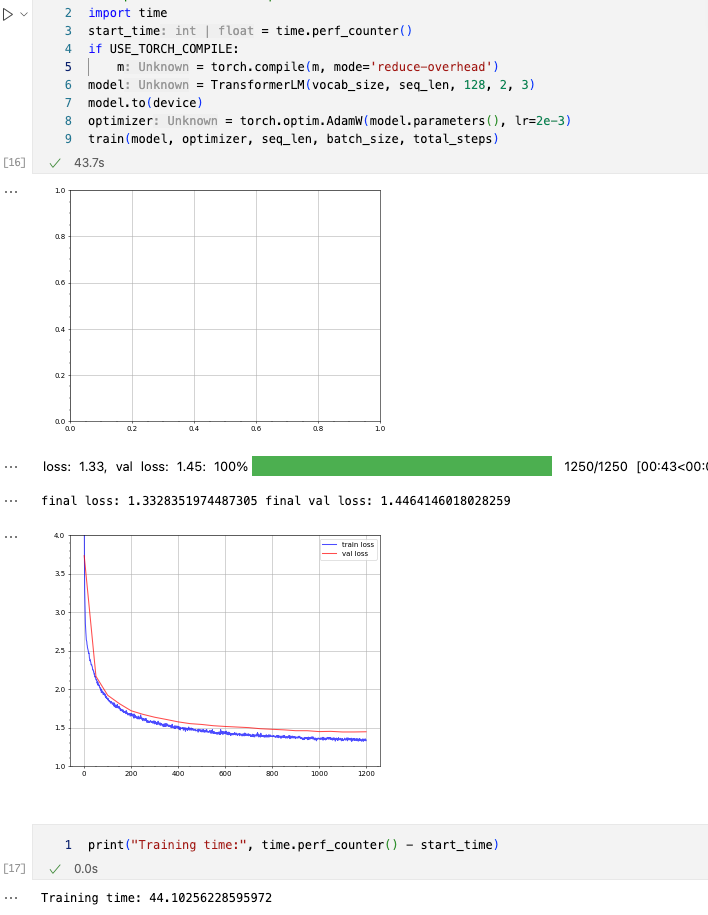

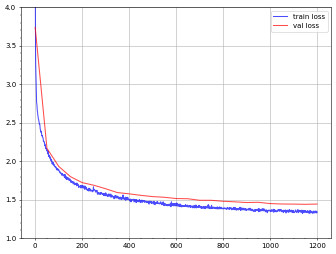

  0%|          | 0/1250 [00:00<?, ?it/s]

final loss: 1.3349370956420898 final val loss: 1.442538809776306


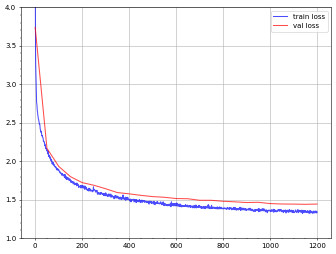

In [16]:
import time
model = TransformerLM(vocab_size, seq_len, 128, 2, 3)
model.to(device)
if USE_TORCH_COMPILE:
    model = torch.compile(model, mode='reduce-overhead')
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)

# Run the compile model once to warm up the cache
xb, yb = get_batch('train', seq_len, batch_size)
logits, loss = model(xb, yb)

# start training

start_time = time.perf_counter()
train(model, optimizer, seq_len, batch_size, total_steps)

In [17]:
print("Training time:", time.perf_counter() - start_time)

Training time: 44.896907698363066


In [19]:
# Save
torch.save(model.state_dict(), 'TransformerLM.pt')

In [20]:
# Load model
model = TransformerLM(vocab_size, seq_len, 128, 2, 3)
model.load_state_dict(torch.load('TransformerLM.pt'))
model.to(device)

RuntimeError: Error(s) in loading state_dict for TransformerLM:
	Missing key(s) in state_dict: "token_embedding_table.weight", "lm_head.weight", "lm_head.bias", "blocks.0.sa_heads.heads.0.tril", "blocks.0.sa_heads.heads.0.key.weight", "blocks.0.sa_heads.heads.0.query.weight", "blocks.0.sa_heads.heads.0.value.weight", "blocks.0.sa_heads.heads.1.tril", "blocks.0.sa_heads.heads.1.key.weight", "blocks.0.sa_heads.heads.1.query.weight", "blocks.0.sa_heads.heads.1.value.weight", "blocks.0.sa_heads.o.weight", "blocks.0.sa_heads.o.bias", "blocks.0.ff_layer.lin_1.weight", "blocks.0.ff_layer.lin_1.bias", "blocks.0.ff_layer.lin_2.weight", "blocks.0.ff_layer.lin_2.bias", "blocks.0.sa_norm.weight", "blocks.0.ff_norm.weight", "blocks.1.sa_heads.heads.0.tril", "blocks.1.sa_heads.heads.0.key.weight", "blocks.1.sa_heads.heads.0.query.weight", "blocks.1.sa_heads.heads.0.value.weight", "blocks.1.sa_heads.heads.1.tril", "blocks.1.sa_heads.heads.1.key.weight", "blocks.1.sa_heads.heads.1.query.weight", "blocks.1.sa_heads.heads.1.value.weight", "blocks.1.sa_heads.o.weight", "blocks.1.sa_heads.o.bias", "blocks.1.ff_layer.lin_1.weight", "blocks.1.ff_layer.lin_1.bias", "blocks.1.ff_layer.lin_2.weight", "blocks.1.ff_layer.lin_2.bias", "blocks.1.sa_norm.weight", "blocks.1.ff_norm.weight", "blocks.2.sa_heads.heads.0.tril", "blocks.2.sa_heads.heads.0.key.weight", "blocks.2.sa_heads.heads.0.query.weight", "blocks.2.sa_heads.heads.0.value.weight", "blocks.2.sa_heads.heads.1.tril", "blocks.2.sa_heads.heads.1.key.weight", "blocks.2.sa_heads.heads.1.query.weight", "blocks.2.sa_heads.heads.1.value.weight", "blocks.2.sa_heads.o.weight", "blocks.2.sa_heads.o.bias", "blocks.2.ff_layer.lin_1.weight", "blocks.2.ff_layer.lin_1.bias", "blocks.2.ff_layer.lin_2.weight", "blocks.2.ff_layer.lin_2.bias", "blocks.2.sa_norm.weight", "blocks.2.ff_norm.weight". 
	Unexpected key(s) in state_dict: "_orig_mod.token_embedding_table.weight", "_orig_mod.lm_head.weight", "_orig_mod.lm_head.bias", "_orig_mod.blocks.0.sa_heads.heads.0.tril", "_orig_mod.blocks.0.sa_heads.heads.0.key.weight", "_orig_mod.blocks.0.sa_heads.heads.0.query.weight", "_orig_mod.blocks.0.sa_heads.heads.0.value.weight", "_orig_mod.blocks.0.sa_heads.heads.1.tril", "_orig_mod.blocks.0.sa_heads.heads.1.key.weight", "_orig_mod.blocks.0.sa_heads.heads.1.query.weight", "_orig_mod.blocks.0.sa_heads.heads.1.value.weight", "_orig_mod.blocks.0.sa_heads.o.weight", "_orig_mod.blocks.0.sa_heads.o.bias", "_orig_mod.blocks.0.ff_layer.lin_1.weight", "_orig_mod.blocks.0.ff_layer.lin_1.bias", "_orig_mod.blocks.0.ff_layer.lin_2.weight", "_orig_mod.blocks.0.ff_layer.lin_2.bias", "_orig_mod.blocks.0.sa_norm.weight", "_orig_mod.blocks.0.ff_norm.weight", "_orig_mod.blocks.1.sa_heads.heads.0.tril", "_orig_mod.blocks.1.sa_heads.heads.0.key.weight", "_orig_mod.blocks.1.sa_heads.heads.0.query.weight", "_orig_mod.blocks.1.sa_heads.heads.0.value.weight", "_orig_mod.blocks.1.sa_heads.heads.1.tril", "_orig_mod.blocks.1.sa_heads.heads.1.key.weight", "_orig_mod.blocks.1.sa_heads.heads.1.query.weight", "_orig_mod.blocks.1.sa_heads.heads.1.value.weight", "_orig_mod.blocks.1.sa_heads.o.weight", "_orig_mod.blocks.1.sa_heads.o.bias", "_orig_mod.blocks.1.ff_layer.lin_1.weight", "_orig_mod.blocks.1.ff_layer.lin_1.bias", "_orig_mod.blocks.1.ff_layer.lin_2.weight", "_orig_mod.blocks.1.ff_layer.lin_2.bias", "_orig_mod.blocks.1.sa_norm.weight", "_orig_mod.blocks.1.ff_norm.weight", "_orig_mod.blocks.2.sa_heads.heads.0.tril", "_orig_mod.blocks.2.sa_heads.heads.0.key.weight", "_orig_mod.blocks.2.sa_heads.heads.0.query.weight", "_orig_mod.blocks.2.sa_heads.heads.0.value.weight", "_orig_mod.blocks.2.sa_heads.heads.1.tril", "_orig_mod.blocks.2.sa_heads.heads.1.key.weight", "_orig_mod.blocks.2.sa_heads.heads.1.query.weight", "_orig_mod.blocks.2.sa_heads.heads.1.value.weight", "_orig_mod.blocks.2.sa_heads.o.weight", "_orig_mod.blocks.2.sa_heads.o.bias", "_orig_mod.blocks.2.ff_layer.lin_1.weight", "_orig_mod.blocks.2.ff_layer.lin_1.bias", "_orig_mod.blocks.2.ff_layer.lin_2.weight", "_orig_mod.blocks.2.ff_layer.lin_2.bias", "_orig_mod.blocks.2.sa_norm.weight", "_orig_mod.blocks.2.ff_norm.weight". 

In [ ]:
model.eval()
idx = encode("You will never")
print(torch.tensor([idx]))
print(decode(model.generate(idx=torch.tensor([idx], dtype=torch.long).to(device), max_new_tokens=1000, temperature=0.5, use_cache=True)[0].tolist()))

tensor([[53, 72, 78,  1, 80, 66, 69, 69,  1, 71, 62, 79, 62, 75]])


You will never decided that one.

I was going to be some time of lonely take any of that the same of the right and the best in times.

The exactly of Pokemon at gives me to be a human part of the transform on the Princess temperatures that man in the stars!

That's what they it was a lot of it.

That's what the hell.

I'm not become a little thing that store?

What about that all the starts!

The funny time to make the based of the guild me.

I'll take it once in a little good soon of the situation of the money.

You know he did he has been the contract of the special to continue of the started with the time and destiny to make me a bit of the started serialization and comment to the teach of the time.

The picture of the start of the stars for the same of the face of the same of the Port the country of the cards on the starts of the torment of his time for that any of a part of the team and we do that that fact the start is all the consult to do it was a good continued.

The festival 

: 

## Classic Transformer With MTP

In [ ]:

head_num = 16
layer_num = 25

kv_cache = [[None for _ in range(head_num)] for _ in range(layer_num)]
for row in kv_cache:
    print(kv_cache)

[[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None], [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None], [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None], [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None], [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None], [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None], [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None], [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None], [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None], [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None], [None, None, None, 

In [ ]:
head_num = 16
layer_num = 25
n_future_tokens = 4

kv_cache = [[None for _ in range(head_num)] for _ in range(layer_num - n_future_tokens + 1)]
kv_cache.append([[None for _ in range(head_num)] for _ in range(n_future_tokens)]) # only one layer but has multiple heads in parallel
print("Using tabs as separators:")
for row in kv_cache:
    # Convert all items in the row to string and join with a tab
    print(row)

Using tabs as separators:
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
[Non

In [ ]:
def precompute_freqs_cis(dim: int, end: int, theta: float = 10000.0):
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
    t = torch.arange(end, device=freqs.device, dtype=torch.float32)
    freqs = torch.outer(t, freqs)
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)  # complex64
    return freqs_cis.to(device)

def apply_rotary_emb(
    xq: torch.Tensor,
    xk: torch.Tensor,
    freqs_cis: torch.Tensor,
):
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
    # freqs_cis = reshape_for_broadcast(freqs_cis, xq_)
    q_shape = [d if i == 1 or i == xq_.ndim - 1 else 1 for i, d in enumerate(xq_.shape)]
    k_shape = [d if i == 1 or i == xk_.ndim - 1 else 1 for i, d in enumerate(xk_.shape)]
    T_q = xq_.shape[-2]
    q_freqs_cis = freqs_cis[-T_q:].view(*q_shape)
    k_freqs_cis = freqs_cis.view(*k_shape)
    xq_out = torch.view_as_real(xq_ * q_freqs_cis).flatten(2)
    xk_out = torch.view_as_real(xk_ * k_freqs_cis).flatten(2)
    return xq_out.type_as(xq), xk_out.type_as(xk)

class RMSNorm(torch.nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(x.float()).type_as(x)
        return output * self.weight

class SelfAttentionHead(nn.Module):
    """ one head of self-attention """
    def __init__(self, seq_len, n_embd, head_size):
        super().__init__()
        self.seq_len = seq_len
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(seq_len, seq_len)))

    def forward(self, x, freqs_cis, kv_cache=None):
        B, T, C = x.shape
        _, T_past, _ = kv_cache[0].shape if kv_cache is not None and kv_cache[0] is not None else (0, 0, 0)
        q = self.query(x) # (B,T,C)
        k = self.key(x)   # (B,T,C)
        v = self.value(x) # (B,T,C)

        if kv_cache is not None:
            k_past, v_past = kv_cache
            if k_past is not None:
                k = torch.cat((k_past, k), dim=1)
                v = torch.cat((v_past, v), dim=1)
            if k.shape[1] > seq_len:
                k = k[:, -seq_len:]
                v = v[:, -seq_len:]
                freqs_cis = freqs_cis[-seq_len:]
            kv_cache = (k, v)

        q, k = apply_rotary_emb(q, k, freqs_cis)

        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei * C**-0.5 # scaled attention
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)

        # perform the weighted aggregation of the values
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out, kv_cache

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """
    def __init__(self, seq_len, num_heads, n_embd, head_size):
        super().__init__()
        self.heads = nn.ModuleList([SelfAttentionHead(seq_len, n_embd, head_size) for _ in range(num_heads)])
        self.o = nn.Linear(num_heads*head_size, n_embd)

    def forward(self, x, freqs_cis, kv_cache=None):
        head_outs = [h(x, freqs_cis, None if kv_cache is None else kv_cache[i]) for i, h in enumerate(self.heads)]
        kv_cache = [h[1] for h in head_outs]
        out = torch.cat([h[0] for h in head_outs], dim=-1) # concat single-head results
        out = self.o(out)
        return out, kv_cache

class FeedForward(nn.Module):
    def __init__(self, n_embed, n_hidden):
        super().__init__()
        self.lin_1 = nn.Linear(n_embed, n_hidden)
        self.lin_2 = nn.Linear(n_hidden, n_embed)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.lin_1(x)
        x = self.relu(x)
        x = self.lin_2(x)
        return x

class Block(nn.Module):
    def __init__(self, seq_len, n_heads, n_embd):
        super().__init__()
        self.sa_heads = MultiHeadAttention(seq_len, n_heads, n_embd, n_embd//n_heads)
        self.ff_layer = FeedForward(n_embd, n_embd*4)
        self.sa_norm = RMSNorm(n_embd)
        self.ff_norm = RMSNorm(n_embd)
    
    def forward(self, x, freqs_cis, kv_cache=None):
        a, kv_cache = self.sa_heads(self.sa_norm(x), freqs_cis, kv_cache)
        h = x + a
        o = h + self.ff_layer(self.ff_norm(h))
        return o, kv_cache
    
class MTPTransformerLM(nn.Module):
    def __init__(self, vocab_size, seq_len, embed_size, head_num, layer_num, n_future_tokens: int = 1):
        """ Transformer Language Model """
        super().__init__()
        self.layer_num = layer_num
        self.head_num = head_num
        self.seq_len = seq_len
        self.n_future_tokens = n_future_tokens # NTP is 1
        # embed raw tokens to a lower dimensional embedding with embed_size
        self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
        # Language Modelling (?) Head is a standard linear layer to go from 
        # embeddings back to logits of vocab_size
        self.lm_head = nn.Linear(embed_size, vocab_size)
        # transformer blocks
        self.blocks = nn.ModuleList()
        for layer_id in range(self.layer_num - self.n_future_tokens):
            self.blocks.append(Block(seq_len, head_num, embed_size))
        # precompute frequencies for rotary embeddings
        self.freqs_cis = precompute_freqs_cis(embed_size//head_num, seq_len*2)
        # extra head for MTP
        self.extra_heads = nn.ModuleList()
        for layer_id in range(self.layer_num - self.n_future_tokens, self.layer_num):
            self.extra_heads.append(Block(seq_len, head_num, embed_size))

    def forward(self, idx, targets=None, kv_cache=None, return_all_heads: bool = True):
        B, T = idx.shape
        _, T_past, _ = kv_cache[0][0][0].shape if kv_cache is not None and kv_cache[0][0][0] is not None else (0, 0, 0)
        # idx and targets are both (B,T) tensor of integers
        tok_embd = self.token_embedding_table(idx) # (B,T,C)
        x = tok_embd
        # go through blocks
        freqs_cis = self.freqs_cis[:T_past+T]
        for i, block in enumerate(self.blocks[:-1]):
            x, cache = block(x, freqs_cis, None if kv_cache is None else kv_cache[i])
            if kv_cache is not None:
                kv_cache[i] = cache
        # get logits with linear layer
        trunk = x # (B,T,C)

        latents = []
        n_heads_to_use = self.n_future_tokens if return_all_heads else 1
        prediction_heads = [self.blocks[-1]] + list(self.extra_heads)
        for i, block in enumerate(prediction_heads[:n_heads_to_use]):
            x, cache = block(trunk, freqs_cis, None if kv_cache is None else kv_cache[-1][i])
            if kv_cache is not None:
                kv_cache[-1][i] = cache
            latents.append(x)

        x = torch.stack(latents, dim=-2) # (B, T, n_heads_to_use, C)

        all_logits = self.lm_head(x) # (B,T, n_heads_to_use,C)

        if targets is None:
            loss = None
        else:
            B, T, n_heads_to_use, C = all_logits.shape
            logits_flat = all_logits.view(-1, C) # (B*T*n_heads_to_use, C)
            targets_flat = targets.view(-1) # (B*T*n_heads_to_use)
            loss = F.cross_entropy(logits_flat, targets_flat)

        final_logits = all_logits[:, :, -1, :] if return_all_heads else all_logits[:,:, 0,:]
        return logits, loss
    
    def generate(self, idx, max_new_tokens, temperature=1, use_cache=True):
        if use_cache:
            # initialize key-value cache
            if self.n_future_tokens == 0:
                kv_cache = [[(None, None) for _ in range(self.head_num)] for _ in range(self.layer_num)]
            else:
                kv_cache = [[(None, None) for _ in range(self.head_num)] for _ in range(self.layer_num - self.n_future_tokens + 1)]
                kv_cache.append([[(None, None) for _ in range(self.head_num)] for _ in range(self.n_future_tokens)]) # only one layer but has multiple heads in parallel
            # idx is (B, T) array of indices in the current context
            # crop idx to the last seq_len tokens
            idx_context = idx[:, -self.seq_len:]
            for _ in range(max_new_tokens):
                # get the predictions
                logits, loss = self(idx_context, kv_cache=kv_cache)
                # focus only on the last time step
                logits = logits[:, -1, :] # becomes (B, C)
                # apply temperature
                logits = logits / temperature if temperature > 0 else logits
                # apply softmax to get probabilities
                probs = F.softmax(logits, dim=-1) # (B, C)
                # sample from the distribution
                idx_next = torch.multinomial(probs, num_samples=1) if temperature > 0 else torch.argmax(probs, dim=-1, keepdim=True) # (B, 1)
                # append sampled index to the running sequence
                idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
                # since we have kv cache, only need to pass new token
                idx_context = idx_next
            return idx
        else:
            # idx is (B, T) array of indices in the current context
            for _ in range(max_new_tokens):
                #crop idx to the last seq_len tokens
                idx_context = idx[:, -self.seq_len:]
                # get the predictions
                logits, loss = self(idx_context)
                # focus only on the last time step
                logits = logits[:, -1, :] # becomes (B, C)
                # apply temperature
                logits = logits / temperature if temperature > 0 else logits
                # apply softmax to get probabilities
                probs = F.softmax(logits, dim=-1) # (B, C)
                # sample from the distribution
                idx_next = torch.multinomial(probs, num_samples=1) if temperature > 0 else torch.argmax(probs, dim=-1, keepdim=True) # (B, 1)
                # append sampled index to the running sequence
                idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
            return idx

In [67]:
# Test forward pass
n_future_tokens = 2
m = MTPTransformerLM(
    vocab_size, 
    seq_len, 
    128, 
    2, 
    5, 
    n_future_tokens
)
m.to(device)
xb, yb = get_batch('train', 5, 1, n_future_tokens)
logits, loss = m(xb, yb)
total_params = sum(p.numel() for p in m.parameters() if p.requires_grad)
total_params

1010262

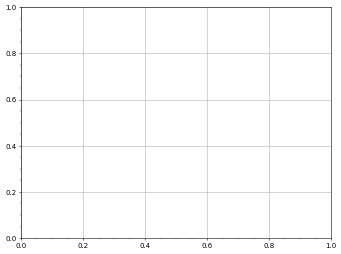

  0%|          | 0/1250 [00:00<?, ?it/s]

KeyboardInterrupt: 

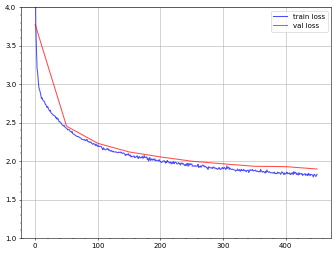

In [68]:
# training!
model = MTPTransformerLM(
    vocab_size, 
    seq_len, 
    128, 
    2, 
    5, 
    n_future_tokens
)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
train(model, optimizer, seq_len, batch_size, total_steps, n_future_tokens=n_future_tokens)

In [ ]:
# Save
torch.save(model.state_dict(), 'TransformerLM.pt')

In [ ]:
# Load model
model = TransformerLM(vocab_size, seq_len, 128, 2, 3)
model.load_state_dict(torch.load('TransformerLM.pt'))
model.to(device)

TransformerLM(
  (token_embedding_table): Embedding(86, 128)
  (lm_head): Linear(in_features=128, out_features=86, bias=True)
  (blocks): ModuleList(
    (0-2): 3 x Block(
      (sa_heads): MultiHeadAttention(
        (heads): ModuleList(
          (0-1): 2 x SelfAttentionHead(
            (key): Linear(in_features=128, out_features=64, bias=False)
            (query): Linear(in_features=128, out_features=64, bias=False)
            (value): Linear(in_features=128, out_features=64, bias=False)
          )
        )
        (o): Linear(in_features=128, out_features=128, bias=True)
      )
      (ff_layer): FeedForward(
        (lin_1): Linear(in_features=128, out_features=512, bias=True)
        (lin_2): Linear(in_features=512, out_features=128, bias=True)
        (relu): ReLU()
      )
      (sa_norm): RMSNorm()
      (ff_norm): RMSNorm()
    )
  )
)

In [ ]:
model.eval()
idx = encode("You will never")
print(torch.tensor([idx]))
print(decode(model.generate(idx=torch.tensor([idx], dtype=torch.long).to(device), max_new_tokens=1000, temperature=0.5, use_cache=True)[0].tolist()))

tensor([[53, 72, 78,  1, 80, 66, 69, 69,  1, 71, 62, 79, 62, 75]])


You will never decided that one.

I was going to be some time of lonely take any of that the same of the right and the best in times.

The exactly of Pokemon at gives me to be a human part of the transform on the Princess temperatures that man in the stars!

That's what they it was a lot of it.

That's what the hell.

I'm not become a little thing that store?

What about that all the starts!

The funny time to make the based of the guild me.

I'll take it once in a little good soon of the situation of the money.

You know he did he has been the contract of the special to continue of the started with the time and destiny to make me a bit of the started serialization and comment to the teach of the time.

The picture of the start of the stars for the same of the face of the same of the Port the country of the cards on the starts of the torment of his time for that any of a part of the team and we do that that fact the start is all the consult to do it was a good continued.

The festival 